# Assignment 2

Welcome to your assignment 2! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook and also submit the .py file that is generated.__

In [1]:
## This code snippet does not need to be edited
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
from python_environment_check import check_packages
from python_environment_check import set_background

## Colour schemes for setting background colour
white_bgd = 'rgba(0,0,0,0)'
red_bgd = 'rgba(255,0,0,0.2)'

[OK] Your Python version is 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
## Code snippets in red (similar to this) is where you need to edit your answer)
# Set your student ID and name here:

student_number = 12345678  # 12345678
student_name = "John Doe" # "John Doe"

set_background(red_bgd)

### Import required libraries and packages

Edit _PATH\_DATASETS_ to the directory that you are using.

Note you do not have to use google colab

In [3]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    

    PATH_DATASETS = '/content/gdrive/MyDrive/_TA_job_Monash/2022_Sem2/ECE4179/Assignment2_draft'
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: .


In [4]:
# Run the installation if you don't have the packages already
# !pip install carbontracker -qq

# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning carbontracker -qq

import copy
import time
import os
import random
import numpy as np
import pandas as pd
import imutils
import matplotlib.pyplot as plt
import math
from PIL import Image
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
from torchvision.datasets import SVHN
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from IPython.core.display import display
from torchmetrics import Accuracy, MeanSquaredError
from IPython.display import clear_output

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint

from carbontracker.tracker import CarbonTracker

from torch.optim.lr_scheduler import StepLR

BATCH_SIZE = 256 if torch.cuda.is_available() else 64


# For reproducability
seed_everything(1234, workers=True )

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 4 ## Set to your device

C:\Users\DELL\AppData\Local\Temp\ipykernel_32472\2175584111.py:34: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
Global seed set to 1234


# DAE: Denoising Autoencoder with MNIST

<div class="alert alert-block alert-info">

## What you should do in this task!

In this task you will be training an autoencoder to denoise images using Pytorch and PyTorch Lightning funtionalities we have previously encountered!

Use Pytorch and the Pytorch Lightning module class to create an autoencoder architecture in order to denoise compomised (noisy) MNIST data, and train your model using stochastic gradient descent (SGD). Note that we will be using an MLP instead of a CNN to build our autoencoder in this task. 
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders.
 2. Visualise a training sample using the dataloader.
 3. Design the neural network model.
 4. Perform training of the model and evaluation.
 5. Visualise experimental results.
    
<img src="figures/denoising_ae.png" width="700" align="center">

### DAE1: Create dataloader for MNIST. Visualise a few samples.

Use the 'random_split' function to divide the training dataset into Train and Validation. You must use 20% of the training data as Validation data during training.

In [9]:
set_background(red_bgd)
## Load in dataloader

# Download MNIST dataset from torchvision and create datasets
train_dataset = torchvision.datasets.MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.MNIST(PATH_DATASETS, train=False, download=True, transform=transforms.ToTensor())

# Perform Random Split
train_size = int(len(train_dataset)*0.8)
val_size = int(len(train_dataset)*0.2)
train_data, val_data = random_split(train_dataset, [train_size,val_size])
BATCH_SIZE = 256

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)

Let's add some noise to the data samples!

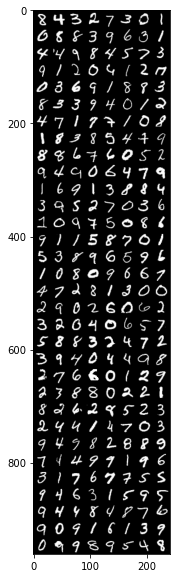

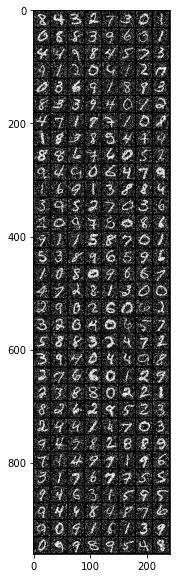

In [18]:
set_background(red_bgd)
## Create noisy samples by adding a 40% (hence 0.4) noise percentage. 
## You can use torch.randn_like(data) * noise_percentage to generate noise based around the data's distribution
## These will just be temporary noisy images. You will add in the noise during the training_step of your Simple_AE class later on.

data, labels = next(iter(train_loader))

# Create noisy data
noise_percentage = 0.4
noisy_data = data + torch.randn_like(data) * noise_percentage
noisy_data = torch.clip(noisy_data,0,1) ## Clip the data between 0 and 1. Look at the documentation for torch.clip()


# visualize clean dataset using torchvision grid
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data) ## Remember to call plt.imshow
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))

# visualize noisy dataset using torchvision grid
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(noisy_data) ## Remember to call plt.imshow
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)))

### DAE2: Design your network architecture for AE

In this task, you will create the encoder and decoder modules that you will use within your "Simple_AE" class (which will be your DAE).

The encoder will just consist of one layer with an activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer with an activation function.

In [38]:
set_background(red_bgd)

class Encoder(nn.Module):    
    def __init__(self):
        super().__init__()
        
        ### Encoder section

        linear_layer = nn.Linear(28*28,128) ## 128 neurons as the output
        
        self.encoder = nn.Sequential(
            linear_layer, ## Add BatchNorm1d() as the next one in the sequence. Then add nn.ReLU(). Note BatchNorm1d takes an input argument.
            nn.BatchNorm1d(128),
            nn.ReLU(True)
        )
        
    def forward(self, x):
    
        ## Forward pass of your encoder
        output = self.encoder(x)
        return x
    
    
class Decoder(nn.Module):   
    def __init__(self):
        super().__init__()
        
        linear_layer = nn.Linear(128,10) ## What should this be? Remember AEs are usually symmetrical
        
        ## Decoder section
        self.decoder = nn.Sequential(
            linear_layer, ## Add in ReLU as the next layer.
            nn.ReLU(True) 
        )
        
    def forward(self, x):
        
        ## Forward pass through your decoder
        ## Pass the output of your decoder into a sigmoid function
        ## Ensure you reshape to B x C x H x W
        output= self.decoder(x)
        print(output.shape)
        return output

Create your autoencoder class '_Simple_AE_' using LightningModule and call the Encoder and Decoder Blocks you have defined above.

In [41]:
set_background(red_bgd)


#Let's create a simple DAE based on MLP networks
class Simple_AE(LightningModule):
    
    def __init__(self, num_classes=10, learning_rate=1e-4):
        super().__init__()
        
        self.learning_rate = learning_rate  ## Use learning rate provided
        self.num_classes = num_classes  ## Use the number of classes provided
        self.criterion = nn.CrossEntropyLoss()   ## Define your loss
        
        self.encoder = Encoder()  ## Initialise your encoder 
        self.decoder = Decoder()  ## Initialise your decoder
        
        self.train_accuracy = Accuracy()  ## Set accuracy, what would be appropriate?
        self.test_accuracy = Accuracy() ## Set accuracy, what would be appropriate?
        self.val_accuracy = Accuracy()
        
    def forward(self, x):
        ## Forward pass through encoder and decoder
        ## Is the result the same shape as your original image? Worth to double check!
        bs = x.shape[0]
        x = x.reshape(bs, -1).float()
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch  
        noisy_data = x + torch.randn_like(x) * 0.4   ## Add in noise to your data here, it is the same as the previous part
        noisy_data = torch.clip(x,0,1) ## Clip your data between 0 and 1. You can use torch.clip()
        
        ## Remember, this is where we are training. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        logits = self(noisy_data)
        loss = self.criterion(logits, y) 
        ## Think about what your loss should be comparing against. There are 3 possibilities: original "x", predicted "x", and noisy "x". Which two are correct to predict?
        ## If your model is not converging to a non-noisy output, this loss criterion might be why! (perhaps comparing two wrong values)
        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss ## Don't forget to return loss so that the gradients can be updated
    
    def validation_step(self, batch, batch_idx):
        x, y = batch  ## Validation step is very similar to the training_step
        noisy_data = x + torch.randn_like(x) * 0.4 
        noisy_data = torch.clip(x,0,1)
      
        ## Remember, this is where we are validating. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        logits = self(noisy_data)
        loss = self.criterion(logits, y) 
        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch ## Test step is similar to the validation step
        noisy_data = x + torch.randn_like(x) * 0.4 
        noisy_data = torch.clip(x,0,1)
        
        ## Remember, this is where we are testing. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        
        logits = self(noisy_data)
        loss = self.criterion(logits, y) 
        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        noisy_data = x + torch.randn_like(x) * 0.4 
        noisy_data = torch.clip(x,0,1)

        ## Add your forward pass here
        logits = self(noisy_data)
        preds = logits.argmax(1)
        return [preds, y] ## You can return predicted "x", noisy "x", and original x. That way you can compare the results with what is expected  ! 

    def configure_optimizers(self):
        
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

### DAE3: Train your model and evaluate the DAE results

In [42]:
set_background(red_bgd)

# Initialize the model
model_ae = Simple_AE()

# Define checkpoint callback function to save best model
checkpoint_callback_d = ModelCheckpoint(
    monitor="val_acc",
    dirpath="logs_task_d/",
    save_top_k=1,
    mode="max",
    every_n_epochs=1
)

# Call the Trainer and train the model
trainer_task_d = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_d],
    logger=CSVLogger(save_dir="logs_task_d/"),
)
trainer_task_d.fit(model_ae)

# Test the model and report test accuracy and test loss
trainer_task_d.test()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | CrossEntropyLoss | 0     
1 | encoder        | Encoder          | 100 K 
2 | decoder        | Decoder          | 1.3 K 
3 | train_accuracy | Accuracy         | 0     
4 | test_accuracy  | Accuracy         | 0     
5 | val_accuracy   | Accuracy         | 0     
----------------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.408     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x784 and 128x10)

Visiualise your experimental results. First, take a look at the accuracy for both training and validation. 

In [2]:
set_background(red_bgd)

## Plot both training and validation losses

### DAE4: Visualise predictions along with the clean data

Visualise some predictions along with clean data and noisy data. You can use the predict function from your trainer. Reshape your output accordingly so that it is the same as the input image dimensions. Please plot at least 20 images, and make sure label your visualisations appropriately.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 188it [00:00, ?it/s]

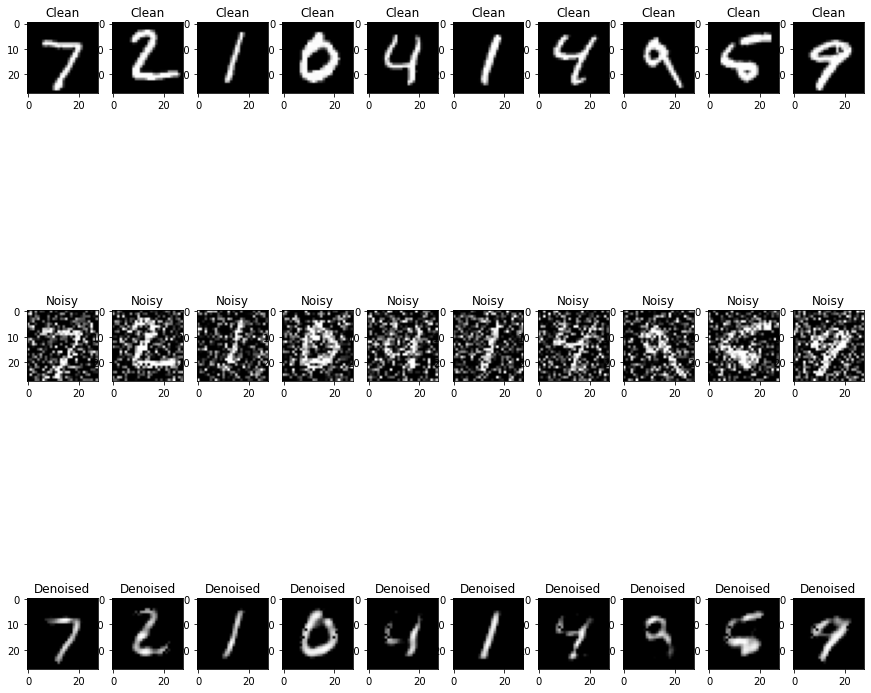

In [ ]:
set_background(red_bgd)


# Generate predictions using predict function
outputs = trainer_task_d.predict(model_ae, test_loader)


## Bonus marks (2% of unit marks)

To earn the bonus marks, you must complete at least two of the given ideas to some satisfactory degree. The ideas/improvements must be related to autoencoders and the MNIST dataset. If you choose to implement your own improvement, it must be something worthwhile (not just simply changing $\lambda$ for example). The results must be shown, and if you end up using any external references, please cite it here and in your report.

Here are a few ideas to choose from:

- Improve the design of the network (hence improve the performance)
- Handle various noise types (speckle noise, Gaussian noise, inpainting etc.)
- Instead of downsampling to a smaller latent space, can you increase it while reducing noise? 
- Any other improvements related to this task

Ensure you add a comment to say what kind of improvements you are trying to make, and why you tackle it in this way!


In [ ]:
## Add in your code here 

# Comparison: MLP vs. CNN - Image Classification on the SVHN dataset

<div class="alert alert-block alert-info">

## What you should do in this task!

In this task you will be training a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) with the SVHN dataset using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt datasets, the Pytorch Lightning module class to construct MLP and CNN, and stochastic gradient descent (SGD) in order to perform training on the SVHN dataset.
    
#### In this task, you will work on the following points:
 1. Download the SVHN train and test datasets and create dataloaders.
 2. Visualise a few training samples using the dataloaders.
 3. Design your neural network models.
 4. Perform training and evaluation of the model.
 5. Visualise experimental results.

<img src="figures/SVHN.png" width="700" align="center">

### C1: Download the SVHN Train and Test set

The Street View House Numbers (SVHN) is a digit classification benchmark dataset that contains 600,000 32×32 RGB images of printed digits (from 0 to 9) cropped from pictures of house number plates. 
SVHN has three sets: 73,257 training images, 26,032 testing images sets and an extra set with 531,131 images that are less difficult and can be used for helping with the training process. 

It also comes from a significantly harder real world problem of recognising digits and numbers in natural scene images. The images lack any contrast normalisation, contain overlapping digits and distracting features which makes it a much more difficult problem compared to MNIST.

More about SVHN dataset: http://ufldl.stanford.edu/housenumbers/

Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models.

In [ ]:
# Define transform to convert image into a Tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Init Train DataLoader from SVHN Dataset
train_ds = SVHN(PATH_DATASETS, split="train", download=True, transform=transform)


# Perform Random Split
train_ds, val_ds = random_split(train_ds, [int(len(train_ds)-math.floor(len(train_ds)*0.2)), math.ceil(int(len(train_ds)*0.2))])

val_loader = DataLoader(val_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 

# Init Test DataLoader from SVHN Dataset
test_ds = SVHN(PATH_DATASETS, split="test", download=True, transform=transform)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE, num_workers=num_workers, persistent_workers=True, pin_memory=True) 

#NOTE:num_workers is the number of threads the dataloader will spawn to load the data from file, 
#you will rarely need more than 4

#NOTE:pin_memory is only useful if you are training with a GPU, if it is True then the GPU will pre-allocate
#memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

Using downloaded and verified file: .\train_32x32.mat
Using downloaded and verified file: .\test_32x32.mat


### C2: Visualise a few training samples
Let's first take a closer look at the shapes of the dataset, and then visualise the mini-batches that the dataloader gives us.

In [ ]:
# We can create an itterater using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 3, 32, 32])
The target output data shape is :
 torch.Size([256])


You can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, where the first dimension (d0) is known as the "batch dimension" (B) and the other three are the image dimensions (CxHxW). We can hence interpret this 4D Tensor as a stack of 256, 3 channel (RGB), 32x32 images.<br>
The image labels on the othe rhand are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


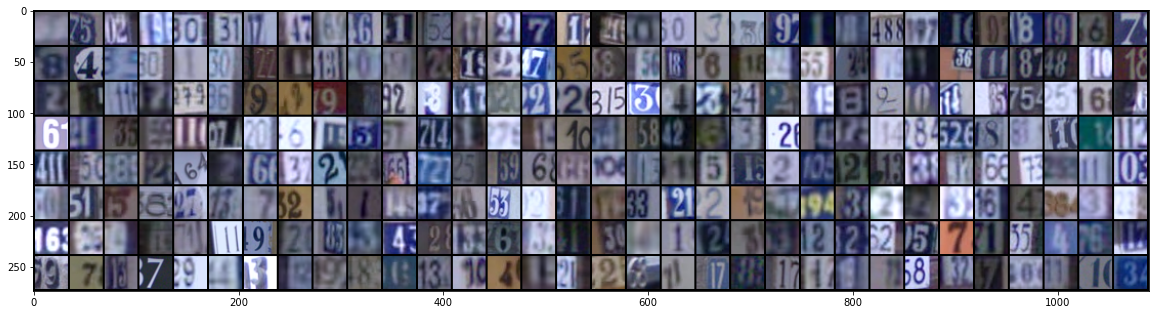

In [ ]:
set_background(red_bgd)

# Lets visualise an entire batch of images!
# Before visualizing make sure to revert normalization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


images2 = copy.deepcopy(inv_normalize(images)) ## Copy the batch so that the reverse normalization does not affect your original images since it will write to memory

## Write your code here to show the mini batch results. 



### C3: Define a MLP and a CNN Model
Define the models using the LightningModule class as usual.

In [ ]:
set_background(red_bgd)


#Let's create a simple MLP network to classify images
class Simple_MLP(LightningModule):
    
    def __init__(self, num_classes=10, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        
        #We will use 3 linear layers
        #The input to the model is 3072 (3x32x32 - the image size (RGB image))
        #and there should be num_classes outputs
        ## FC1 has output of 256
        ## FC2 has output of 32
        ## FC3 has output of num_classes

        self.fc1 = nn.Linear(???)
        self.fc2 = nn.Linear(???)
        self.fc3 = nn.Linear(???)
        
        self.train_accuracy = ??? ## What accuracy do you use in this case
        self.val_accuracy = ???
        self.test_accuracy = ???

        
    def forward(self, x):
        
        #the data we pass the model is a batch of RGB images
        
        #with shape BSx3x32x32 we need to flatten it to BSx3072
        #To use it in a linear layer
        
        
        # Use a relu activation function for this network! (F.relu). Use F.relu for every layer except the last FC layer. 
        
        return ???
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        logits = self(x)
        loss = self.criterion(???) ## Loss
        _, preds = ??? ## Predicted class
        self.train_accuracy.update(???) ## Update your accuracy
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(???) ## Loss
        _, preds = ??? ## Predicted class
        self.val_accuracy.update(???) ## Update your accuracy
        
        # Calling self.log will show scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        
        return preds

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(???) ## Loss
        _, preds = ??? ## Predicted class
        self.test_accuracy.update(???) ## Update your accuracy
        

        # Calling self.log will show scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
        return preds

    def configure_optimizers(self):
        optimizer = ???
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

In [ ]:
set_background(red_bgd)


## We will use modular convolutional blocks. 
## In here, define your activation function as ReLU 
## The convolutional block module will have 2 convolutional layers. 
## The first conv2d will have kernel size = 3, padding = 0, stride = 1
## The second conv2d will have kernel size = 3, padding = 1, stride = 1

## channels_in will only go into the first convolutional block
## channels_out will be used for every other channel

class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out):
        super(ConvBlock, self).__init__()     # Call constructor
        self.act = ??? ## Use RELU
        self.conv1 = nn.Conv2d(???)
        self.conv2 = nn.Conv2d(???)

    def forward(self, x):

        
        return ???


#Let's create a simple CNN for image classification
class Simple_CNN(LightningModule):
    
    def __init__(self, num_classes=10, learning_rate=1e-1):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.criterion = ???
        
        ## Initialise 2 convolutional blocks with:
        ## channel_in = 3, channel_out = 64
        ## channel_in = 64, channel_out = 128
        ## You will also use the global average pooling as well. 
        self.conv_blk1 = ???
        self.conv_blk2 = ???
        
        self.GAP = ???
        
        ## The final fully connected layer will have:
        ## input = 1152, output = num_classes
        self.fc1 = ???
        
        self.train_accuracy = ???  ## Define your accuracy
        self.val_accuracy = ???  ## Define your accuracy
        self.test_accuracy = ??? ## Define your accuracy
        

        
    def forward(self, x):
        
        ## 3 convolutional BLOCKS into a GAP into a FC1. 
        ## Make sure to reshape your output from GAP so that it is flattened


        return ???
    
    def training_step(self, batch, batch_idx):
        x, y = batch  ## Define your training step
        logits = self(x)
        loss = self.criterion(???)
        _, preds = torch.max(???)
        self.train_accuracy.update(???)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss



    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(???)
        _, preds = torch.max(???)
        self.val_accuracy.update(???)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        
        return preds


    def test_step(self, batch, batch_idx):
        x, y = batch  ## Define your test step
        logits = self(x)
        loss = self.criterion(???)
        _, preds = torch.max(???)
        self.test_accuracy.update(???)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        
        return preds

    def configure_optimizers(self):
        optimizer = ???
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return val_loader
    def test_dataloader(self):
        return test_loader

### C4: Train and evaluate both models
Define VisualizeSamplePredictionsCallback using Callback class. You have to visualise 5 sample predictions from the first batch at the end of testing. This will redefine the on_test_batch_end function.

Here is a sample image:
<img src="figures/sample_predictions.png" width="700" align="center">

In [ ]:
set_background(red_bgd)

class VisualizeSamplePredictionsCallback(Callback):
    
    def on_test_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Called when the test batch ends."""
 
        # `outputs` comes from `LightningModule.test_step`, so make sure to return prediction in test_step 
        # which corresponds to our model predictions during testing time in this case
        # Let's log 5 sample image predictions from first batch
        # Make sure to do inverse normalizing before you plot original images
        ???

Note, this training below is slightly different. We have added carbon trackers for you (for discussion later on).

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | CrossEntropyLoss | 0     
1 | fc1            | Linear           | 786 K 
2 | fc2            | Linear           | 8.2 K 
3 | fc3            | Linear           | 330   
4 | train_accuracy | Accuracy         | 0     
5 | val_accuracy   | Accuracy         | 0     
6 | test_accuracy  | Accuracy         | 0     
----------------------------------------------------
795 K     Trainable params
0         Non-trainable params
795 K     Total params
3.181     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\himas\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:02:13
	Energy:	0.000330 kWh
	CO2eq:	0.097231 g
	This is equivalent to:
	0.000808 km travelled by car
CarbonTracker: 
Predicted consumption for 1 epoch(s):
	Time:	0:02:13
	Energy:	0.000330 kWh
	CO2eq:	0.097231 g
	This is equivalent to:
	0.000808 km travelled by car
CarbonTracker: Finished monitoring.


Restoring states from the checkpoint path at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s1\epoch=11-step=2748.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s1\epoch=11-step=2748.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7995544075965881
        test_loss           0.7315568327903748
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7315568327903748, 'test_acc': 0.7995544075965881}]

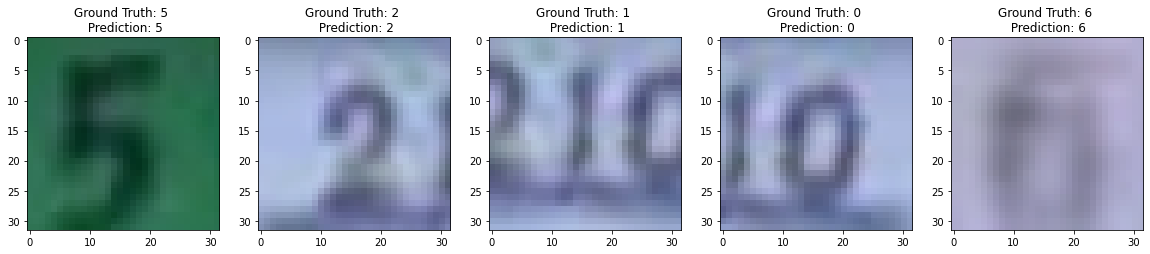

In [ ]:
set_background(red_bgd)

# Initialize the MLP model
max_epochs = 100
model = ???

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback_s1 = ModelCheckpoint(
    ???
    )

# Use the carbon_tracker across the entire max_epochs to reduce output clutter
carbon_tracker_mlp = CarbonTracker(epochs = 1) 

# Stop after 5 epochs of no improvement in validation loss
early_stopping_s1 = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
# We will not include early stopping just so each model trains the same amount of epochs
trainer_task_s1 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs ,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_s1, early_stopping_s1, VisualizeSamplePredictionsCallback()],
    logger=CSVLogger(save_dir="logs_task_s1/"),
)


carbon_tracker_mlp.epoch_start() ## This is not how it is supposed to be used, but it is a lot cleaner than putting it in as a callback function for the pytorch-lightning module

trainer_task_s1.fit(model)

carbon_tracker_mlp.epoch_end()

# Test the model and report test accuracy and test loss
trainer_task_s1.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX 1650.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | criterion      | CrossEntropyLoss  | 0     
1 | conv_blk1      | ConvBlock         | 38.7 K
2 | conv_blk2      | ConvBlock         | 221 K 
3 | GAP            | AdaptiveAvgPool2d | 0     
4 | fc1            | Linear            | 11.5 K
5 | train_accuracy | Accuracy          | 0     
6 | val_accuracy   | Accuracy          | 0     
7 | test_accuracy  | Accuracy          | 0     
-----------------------------------------------------
271 K     Trainable params
0         Non-trainable params
271 K     Total params
1.087     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Predicted consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: 
Predicted consumption for 1 epoch(s):
	Time:	0:23:42
	Energy:	0.025377 kWh
	CO2eq:	7.466111 g
	This is equivalent to:
	0.062011 km travelled by car
CarbonTracker: Finished monitoring.
CarbonTracker: Finished monitoring.


Restoring states from the checkpoint path at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s2\epoch=32-step=7557.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at C:\Users\himas\Documents\ECE4179_2022\ECE4179_2022_Labs-main\ECE4179_2022_Labs-main\Assignment_2\checkpoints_section_s2\epoch=32-step=7557.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9157959222793579
        test_loss           0.30015894770622253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30015894770622253, 'test_acc': 0.9157959222793579}]

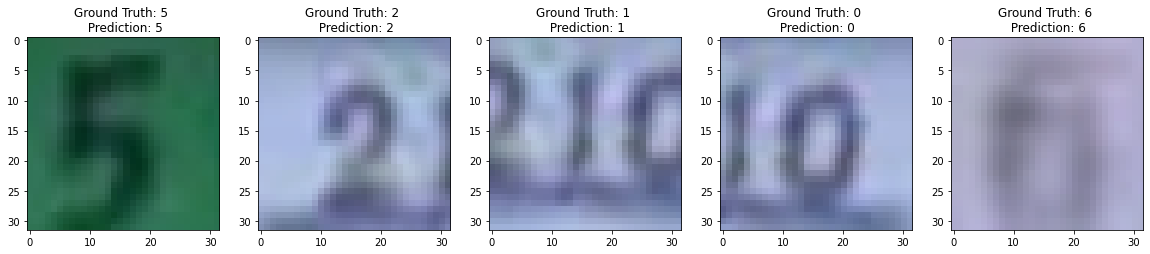

In [ ]:
set_background(red_bgd)

# Initialize the CNN model
max_epochs = 100
model_cnn = ???

# Initialize checkpoint callback to save the best model using validation loss
checkpoint_callback_s2 = ModelCheckpoint(
    ???
    )

# Use the carbon_tracker across the entire max_epochs to reduce output clutter
carbon_tracker_cnn = CarbonTracker(epochs = 1) 

# Stop after 5 epochs of no improvement in validation loss
early_stopping_s2 = EarlyStopping('val_loss', patience = 5, mode='min') 

# Call the Trainer and train the model
trainer_task_s2 = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=max_epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_s2, early_stopping_s2, VisualizeSamplePredictionsCallback()],
    logger=CSVLogger(save_dir="logs_task_s2/"),
)

carbon_tracker_cnn.epoch_start() ## This is not how it is supposed to be used, but it is a lot cleaner than putting it in as a callback function for the pytorch-lightning module

trainer_task_s2.fit(model_cnn)

carbon_tracker_cnn.epoch_end()

# Test the model and report test accuracy and test loss
trainer_task_s2.test()

### C5: Visualise the results for both validation accuracies

Using log files and matplotlib, plot train loss and train accuracy for both models.

In [3]:
set_background(red_bgd)


## Show the MLP and CNN training curves, you should have 4 plots on top of each other
## MLP train loss, MLP train accuracy, CNN train loss, CNN train accuracy
## The x-axis will be epochs

???

plt.figure(figsize=(10, 5))

### C6: Discussion of performance and number of parameters used for each model

Answer the following questions and add in additional discussions

In [ ]:
set_background(red_bgd)


## Discuss the experimental results and the number of parameters used for each model.
## Why does one model outperform another?
## Hint, you can see the number of parameters of each model when the model is first initialised before training   


In [ ]:
set_background(red_bgd)


## Discuss the carbon emissions output for each model



Add in additional discussion. Use some of the tools that you have learnt in previous labs / other sections of this assignment! Note, you need to complete this additional part to be awarded the mark. (Hint: you could even use the next task!)

In [ ]:
set_background(red_bgd)

## Add in additional discussion here. You can include other plots 


# Occlusion Sensitivity Analysis

<div class="alert alert-block alert-info">

## What you should do in this task!
    
For this task, you will use a pretrained ResNet model from TorchHub. Have a look at the documention [here](https://pytorch.org/hub/pytorch_vision_resnet/).

To feed an image to a resnet model, you need to 
1. Resize the image to 224x224 
2. Normalize the image according to the way training images are normalized for resnet models. This includes subtracting the mean and removing the standard deviation (std) from the color channels (i.e., RGB). The mean and the std are computed from the ImageNet dataset and are provided as mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


A good practice to obtain a 224x224 image from an arbitrary one is to first resize the image to 256x256 and then crop the 224x224 part from the center. All of the above can be easily done using transforms from torchvision. Below is an example:

```python
from PIL import Image
from torchvision import transforms
pil_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(pil_image)
```

The PIL [Python Imaging Library](https://pillow.readthedocs.io/en/stable/) is a Python package to read images. In the above code snippet, you first read an image from your HDD (filename is a string showing the file name and its path), and normalize it using the transforms. "img_tensor" will be a torch tensor of size 3x224x224 which you can then use.  

Pay attention to the following:
1. The output of a pretrained resnet models is simply the logit scores. It means the argmax over the output will tell you the class id predicted by the model but you do not have the probablity (or confidence) of the prediction. You should use a softmax function to convert the logit scores into a probability vector.

2. The pretrained resnet models can recognize 1,000 classes. The class names are provided to you as a text file and can be attained from this [link](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).

3. You need to put your model into the __eval__ mode (to disable computation of gradients).

4. At the bottom of this [page](https://pytorch.org/hub/pytorch_vision_resnet/), the error of available models is provided. We recommend you to use resnet18 but feel free to try other models.

### O1: Load pretrained model

In [ ]:
# Load pretrained model using torch hub
resnet_model = ???

# Change model's mode into eval and transfer to the device you are using


### O2: Create Transformations

In [ ]:
# Transformation with normalization
# Ensure you normalize with: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
# Also, make sure your images are 224x224 (since this is what the model was trained on)
preprocess = ???

# Transformation without normalization
preprocess_resize_crop = ???

### O3: Perform occlusion sensitivity analysis

Use the dog image from [here](https://github.com/pytorch/hub/raw/master/images/dog.jpg) and perform occlusion sensitivity analysis to understand what parts of the image are important for the predictions. We recommend you to use a patch of size 20x20 with a stride of 5 for occlusion.

In [ ]:
# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
# img_url : https://github.com/pytorch/hub/raw/master/images/dog.jpg
# Open image using PIL library
img_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
img_pil = ??? # Open image

# Now preprocess above image, use your preprocess object that you have made previously
img_tensor = ???

# Create a mini-batch as expected by the model (here of batchsize 1 - hint: Take a look at 'unsqueeze')
img_batch = ???

In [ ]:
# Define eval_img function to predict pretrained model output for above image
# Input parameters to the function: img_batch, model
# Return values: top1 probability, top1 vategory id, category name (Refer imagenet_classes.txt)
def eval_img(img_batch,model):
    num_imgs = img_batch.shape[0]
    with torch.no_grad():
        output = model(img_batch)

    probabilities = ??? 
    
    # Show top categories per image
    top1_prob, top1_catid = ???

    top1_catid = ???
    
    if num_imgs > 1:
        cat_name = [categories[i] for i in top1_catid]
    else: 
        cat_name = categories[top1_catid]

    return ???

In [ ]:
patch_size = 20
patch_stride = 5

# Call eval_img function
prob0, dummy1, pred_class_name = ???

In [ ]:
# Define occlusion_sensitivity function
# Input parameters to the function: patch_size, patch_stride, img_tensor, model
# Return values: img_prob
    def occlusion_sensitivity(patch_size, patch_stride, img_tensor, model):
    C, H, W = img_tensor.shape
    
    ## Calculate the size of your patch. 
    ## THis can be done by using your patch_size and patch_stride
    ## Sound familiar? 
    ## Hint: look at the calculation for convolution dimensions
    n_patches = np.floor(1+(H-patch_size)/patch_stride).astype(int)
    
    ## Set the patch as zeroes
    img_prob = np.zeros([n_patches,n_patches])

    ## Apply the patch across the entire image
    ## You can go by height first, then by rows
    ## When overlaying your patch across the image, ensure that you .clone() the tensor first
    ## This is because Python uses the memory address when you do "temp_tensor = original_tensor"
    ???
    
    
    ## The final output of img_prob will be the image probabilities corresponding to 
    ## each position of your image based on where your patch was overlaid
    
    
    return img_prob

# Define plot_occlusion_sensitivity function
# Input parameters to the function: img_pil, img_prob
def plot_occlusion_sensitivity(img_pil, img_prob):
    
    ## img_pil is the PIL image
    ## img_prob is the extracted probabilities for each patch
    ## Ensure you use preprocess_resize_crop and transforms.functional.to_pil_image 
    ???
    
    ## Normalize your img_prob between min and max
    ## This way, you can use a heatmap
    ## For example: plt.imshow(occ_sens_arr, cmap="hot")
    ## Ensure you add some coloured bars to the final plot

    ???
    
    plt.colorbar(???)


In [ ]:
img_prob = occlusion_sensitivity(???)

plot_occlusion_sensitivity(???)

In [ ]:
print(pred_class_name)

Now use an image of your choice that the model cannot recognize correctly. For example, this is [Wendy](https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg) but ResNet18 incorrectly classifies it  as a Pembroke (a breed of dog). Perform occlusion senstivity to understand what parts of image are important for its incorrect prediction. Do you give the model some credit for its mistake?

Read more about Wendy [here](https://www.khou.com/article/news/nation-world/eterinarians-in-australia-believe-endangered-dingo-pup-was-dropped-by-an-eagle/507-2658a23e-1144-433d-a215-77474bfd9a71). 

In [ ]:
# img_url : https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg
# Open image using PIL library
img_url = "https://i.cbc.ca/1.5352059.1573161914!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/wandi.jpg"
img_pil = Image.open(requests.get(img_url, stream=True).raw)

# Now preprocess above image
img_tensor = ???

# Create a mini-batch as expected by the model
img_batch = ???

# Evaluate the image
prob0, dummy1, pred_class_name = ???

# Plot occlusion
???

In [ ]:
print(pred_class_name)

# FLD: Face Landmarks Detection with Transfer Learning

<div class="alert alert-block alert-info">

## What you should do in this task!

In this task you will be training a ResNet for the Face Landmark Detection task using Pytorch and PyTorch Lightning funtionalities we have previously seen!

You have to use Pytorch inbuilt models to load the ResNet model, the Pytorch Lightning module class to modify the ResNet architecture in order to detect landmarks of human faces. As always, we will train our model using stochastic gradient descent (SGD).
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders with suggested transformations.
 2. Visualise a training sample with ground truth landmark points.
 3. Design a neural network model (Idea is images should be fed to a CNN and the features from the CNN being used by an MLP).
 4. Perform training and evaluation of the model.
 5. Visualise your experimental results.
    
<img src="figures/face_landmarks.png" width="700" align="center">

### FLD1: Create dataloaders for the face landmarks dataset. Visualise a few samples of the data along with the landmarks

The FLD data can be loaded in completely since it is relatively small.

Have a look at how the data is loaded in to understand how to access the data for the modelling process. You do NOT have to edit the FLD_Data class!

In [ ]:
class FLD_Data(Dataset):
    def __init__(self, trn_tst = 0, transform=transforms.ToTensor()):
        # Load numpy data
        data = np.load(PATH_DATASETS + '/face_landmark.npz')
        if trn_tst == 0:
            # Create dataset for trainloader 
            self.images = data['train_images']
            self.landmarks = data['train_landmarks']
        else:
            # Create dataset for testloader 
            self.images = data['test_images']
            self.landmarks = data['test_landmarks']
            
        self.transform = transform   ## Save the transforms as your class' attributes

    # Define len function
    def __len__(self):
        return len(self.landmarks)

    # Define getitem function
    def __getitem__(self, idx):

        images = self.images[idx,:]
        landmarks = self.landmarks[idx]
        
        if self.transform is not None:  ## If there is a transform, apply it here to your sample
            images = self.transform(images)
            
        return images, landmarks ## Useful for using MSE loss later on

In [ ]:
set_background(red_bgd) 

## Set your train and test datasets

train_dataset = ???
test_dataset = ???

Using the 'random_split' function, create a validation dataset by using 10% of training data.

In [ ]:
set_background(red_bgd)

# split the dataset into validation and test sets
len_valid_set = ??? ## 10% of the validation data
len_train_set = ??? ## 90% of the remaining train data

train_dataset , valid_dataset,  = torch.utils.data.random_split(???) ## Split train data

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(???, batch_size=???, shuffle=???)
valid_loader = torch.utils.data.DataLoader(???, batch_size=???, shuffle=???)
test_loader = torch.utils.data.DataLoader(???, batch_size=???, shuffle=???)

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len(test_dataset)))

The length of Train set is 696
The length of Valid set is 77
The length of Test set is 221


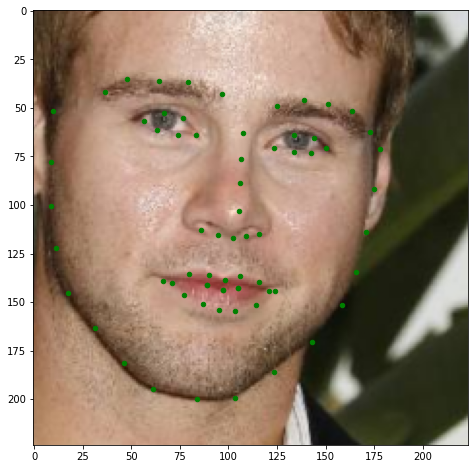

In [ ]:
set_background(red_bgd)

## Visualise a few images along with each image's landmarks



### FLD2: Load a pre-trained ResNet18 network. Adapt the code to include transfer learning

Transfer learning can be employed when the goal is to use pre-trained models (ie. ResNet18) for a new task. The new task can be classification or numerical estimation, but the important thing about transfer learning is that you need to ensure the dataset used for the pre-training is similar in its distribution to the new task. For example, if you pre-trained model was only trained on classifcation of coloured images, it will not perform well for black and white images! 

In this task you need to:
- Load in a ResNet18 model WITH pretrained weights
- Freeze all the parameters of the ResNet18 model (see PDF)
- Replace the current FC layer in the ResNet18 model with a new FC layer (by default, this new FC layer will have non-frozen parameters)

In [ ]:
set_background(red_bgd)


from torchvision.models import resnet18, ResNet18_Weights

class FaceLandmarkDetection(LightningModule):
    def __init__(self, learning_rate=5e-4, num_classes=136):
        super().__init__()
        
        self.learning_rate = learning_rate 
        self.loss_fun = ??? ## Define your loss! What should it be?
        
        self.model_name = "resetnet"
        
        ## Load the pre-trained network as follows
        ## resnet18 from models
        ## Use the importedweights of:   ResNet18_Weights.IMAGENET1K_V1
        ## See pytorch documentation on how to load models with a certain weight
        self.model = ???



        # freeze resnet18 weights (see PDF's hints)
        # You can set the param.requires_grad = False 
        # That way those parameters will not get updated
        # See PDF for additional info
        
        
        ???
       

        # Remake the resnet18 FC layer. You can use the in_features from the original model 
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes) 

        
        self.train_error = ??? ## Which error do we use? Remember, we are dealing with minimising coordinate errors in the landmarks
        self.val_error = ???
        self.test_error = ???

            
    def forward(self, x):
        #Pass input through model
        
    
        return ???
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        landmarks =  ??? ## Ensure you reshape your landmarks data to compare against the preds
        loss = self.loss_fun(???, ???)
        error = self.train_error(???, ???)
        
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_error", error, prog_bar=True, on_step=False, on_epoch=True)
        
        # self.num_epochs += 1

        # if self.trainer.is_last_batch == 0 and (self.num_epochs % 100 == 0):
        #   self.lr_schedulers.step()


        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks =???
        loss = self.loss_fun(???, ???)
        error = self.val_error(???, ???)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_error", error, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        landmarks = ???
        loss = self.loss_fun(???, ???)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)

        
    def predict_step(self, batch, batch_idx):
        
        ???
        
        return ???   ## Return 3 values here: predicted landmarks, original landmarks and the original image

    def configure_optimizers(self):
        
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

### FLD3: Train and Test the model

In [ ]:
## Initialise your face landmark model
## Train until the end of max_epochs or if the early stopping condition has occured
## Note that if you implement it similarly to how we have done it (same hyper parameters etc.)
## Then your epoch should stop around ~110 (+/- 25 epochs)

FaceLandmarkDetection_model = ???

# Define checkpoint callback function to save best model
checkpoint_callback_f = ModelCheckpoint(
        ???
        )

# Train and test the model
trainer_f = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  
    max_epochs=200,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback_f,  EarlyStopping('val_loss', patience  = 10, mode = 'min')],
    logger=CSVLogger(save_dir="logs_task_f/"),
)
trainer_f.fit(???)
trainer_f.test()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params
--------------------------------------------------
0 | loss_fun     | MSELoss          | 0     
1 | model        | ResNet           | 11.2 M
2 | entire_model | Sequential       | 11.2 M
3 | train_error  | MeanSquaredError | 0     
4 | val_error    | MeanSquaredError | 0     
5 | test_error   | MeanSquaredError | 0     
--------------------------------------------------
69.8 K    Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.985    Total estimated model params size (MB

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints_section_f/epoch=100-step=1111.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/checkpoints_section_f/epoch=100-step=1111.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            353.216064453125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 353.216064453125}]

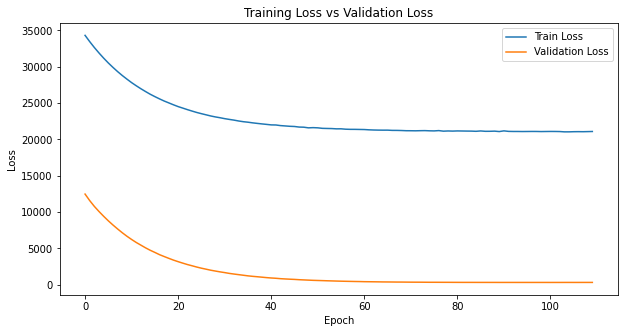

In [ ]:
## Plot your train and validation losses!

???

### FLD4: Visualise predicted landmarks for some of the images

In [ ]:
set_background(red_bgd)


## Utilise the trainer predict method to output the predicted landmarks
## Overlay this with the original landmarks and the original image




### FLD5: Add a discussion about the results

In [ ]:
## Discuss here














## Final remarks

Well done on making it all the way to the end. We hope you have enjoyed applying deep learning concepts to further your understanding and to new applications ! All the best :)

# Do not remove or edit the following code snippet. 

When submitting your report, please ensure that you have run the entire notebook from top to bottom. __Make sure the outputs are clear and visible to the assessor.__ Make sure the last cell (below) has also been run. 

In [ ]:
file_name = str(student_number) + 'Assignment_2'
cmd = "jupyter nbconvert --to script Assignment_2.ipynb --output " + file_name
if(os.system(cmd)):
    print("Error converting to .py")
    print(f"cmd: {cmd}")

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator

In [36]:
def get_y_value(data_x):
    data_y= []
    for x in data_x:
        if x<-1:
            y = np.exp(-1) - np.exp(1)
        elif x>1:
            y = np.exp(1) - np.exp(-1)
        else:
            y = np.exp(x) - np.exp(-x)
        data_y.append(y)
    return data_y 

data_x = list(range(-2,3))
data_y = get_y_value(data_x)

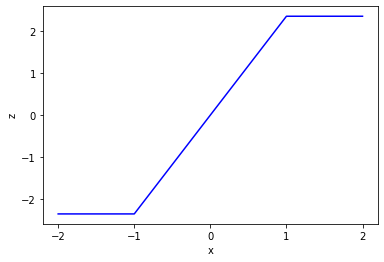

In [37]:
plt.plot(data_x,data_y,"b")
plt.xlabel("x")
plt.ylabel("z")
ax=plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()